# Análisis de Frecuencia de Clientes Wi-Fi

Este notebook permite identificar clientes frecuentes y esporádicos a partir de los datos de RSSI recolectados.

In [1]:
import client_analysis as ca
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# Configuración del gráfico
%matplotlib inline
plt.style.use('ggplot')

## 1. Configuración de Datos
Cambia la variable `CSV_PATH` para apuntar al archivo que deseas analizar.

In [3]:
# Ejemplo: Edificio 990, Octubre
CSV_PATH = "../buildings/990/rssi_2018_03.csv"

try:
    df = ca.load_client_data(CSV_PATH)
    print(f"Datos cargados correctamente: {len(df)} registros.")
except Exception as e:
    print(f"Error: {e}")

Datos cargados correctamente: 1278 registros.


## 2. Estadísticas de Frecuencia
Calculamos cuántas veces aparece cada cliente en el archivo.

In [4]:
freqs = ca.get_client_frequencies(df)
stats = ca.get_frequency_stats(freqs)
print("Resumen estadístico de frecuencias por cliente:")
print(stats)

Resumen estadístico de frecuencias por cliente:
count     20.000000
mean      63.900000
std       84.408717
min        4.000000
25%       10.000000
50%       27.000000
75%       97.500000
max      300.000000
Name: count, dtype: float64


## 3. Visualización
El histograma nos ayuda a decidir un umbral (threshold) para separar clientes frecuentes de esporádicos.

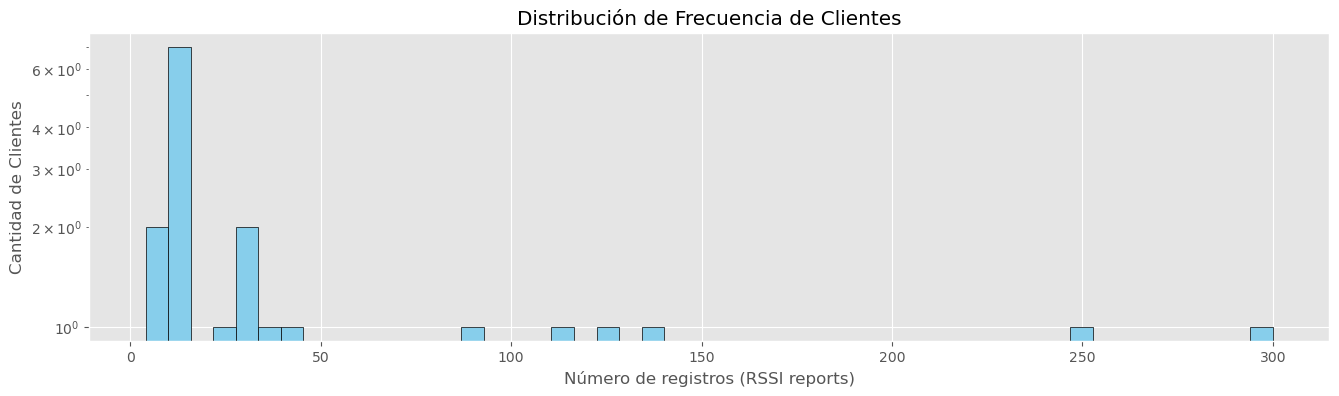

In [6]:
plt.figure(figsize=(16, 4))
plt.hist(freqs, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de Frecuencia de Clientes')
plt.xlabel('Número de registros (RSSI reports)')
plt.ylabel('Cantidad de Clientes')
plt.yscale('log') # Escala logarítmica suele ser mejor para estos datos
plt.show()

## 4. Filtrado de Clientes
Basado en el gráfico anterior, elige un `THRESHOLD`. Los clientes con más o igual cantidad de registros serán considerados frecuentes.

In [7]:
THRESHOLD = 20 # Cambia este valor según tu criterio

frequent, sporadic = ca.categorize_clients(freqs, THRESHOLD)

print(f"Umbral seleccionado: {THRESHOLD}")
print(f"Clientes Frecuentes: {len(frequent)}")
print(f"Clientes Esporádicos: {len(sporadic)}")

# Filtrar el DataFrame original para quedarnos con los frecuentes
df_frequent = ca.filter_by_clients(df, frequent)
print(f"\nRegistros originales: {len(df)}")
print(f"Registros de clientes frecuentes: {len(df_frequent)}")

Umbral seleccionado: 20
Clientes Frecuentes: 11
Clientes Esporádicos: 9

Registros originales: 1278
Registros de clientes frecuentes: 1190


## 5. Ejemplo de Datos Filtrados
Mostramos los primeros registros de los clientes frecuentes.

In [8]:
df_frequent.head()

,mac_cliente,mac_ap,banda,antena,rssi,date,time,client_index,block_index
36,120.228.0.57.52.255,0.66.104.213.240.0,0,0,-61,2018-03-05,15:05,4,1
37,120.228.0.57.52.255,0.66.104.213.240.0,0,1,-74,2018-03-05,15:05,4,1
38,120.228.0.57.52.255,44.208.45.106.167.16,0,0,-91,2018-03-05,15:05,4,1
39,120.228.0.57.52.255,44.208.45.106.167.16,0,1,-91,2018-03-05,15:05,4,1
40,120.228.0.57.52.255,44.208.45.125.172.128,0,0,-84,2018-03-05,15:05,4,1


## 6. Análisis por banda

In [9]:
band_counts = df_frequent['banda'].value_counts()

print("Cantidad de registros por banda para clientes frecuentes:")
print(band_counts)

Cantidad de registros por banda para clientes frecuentes:
banda
0    978
1    212
Name: count, dtype: int64


Análisis de RSSI para clientes frecuentes por banda:
       count       mean        std   min   25%   50%   75%   max
banda                                                           
0      978.0 -78.817996  19.247449 -99.0 -95.0 -87.0 -64.0 -30.0
1      212.0 -69.740566  13.104164 -93.0 -81.0 -70.0 -59.0 -42.0


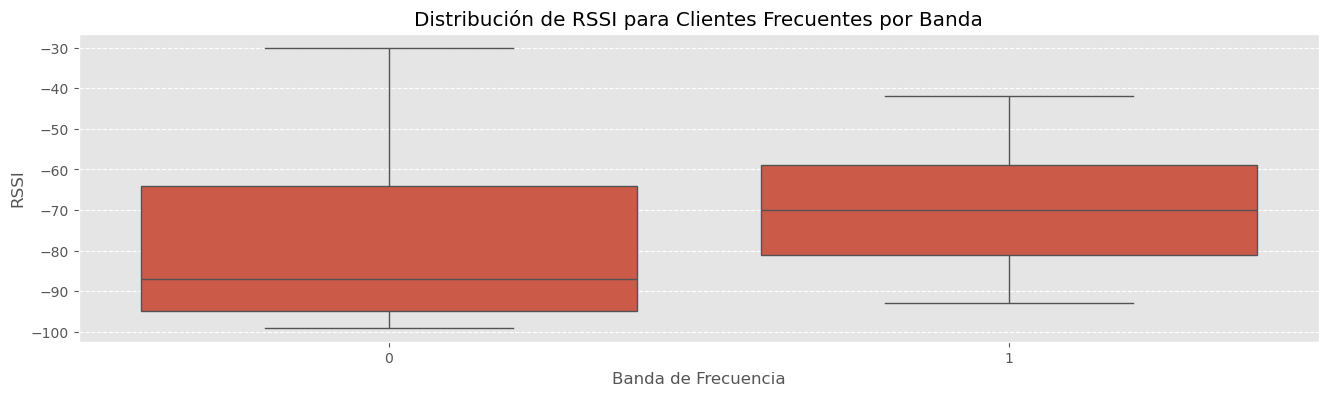

In [10]:
band_analysis = df_frequent.groupby('banda')['rssi'].describe()

print("Análisis de RSSI para clientes frecuentes por banda:")
print(band_analysis)

plt.figure(figsize=(16, 4))
sns.boxplot(x='banda', y='rssi', data=df_frequent)
plt.title('Distribución de RSSI para Clientes Frecuentes por Banda')
plt.xlabel('Banda de Frecuencia')
plt.ylabel('RSSI')
plt.grid(axis='y', linestyle='--')
plt.show()

## 7. Análisis de RSSI para Clientes Frecuentes por Antena

In [14]:
antena_analysis = df_frequent.groupby(['antena','banda'])['rssi'].describe()

print("Análisis de RSSI para clientes frecuentes por antena:")
print(antena_analysis)

Análisis de RSSI para clientes frecuentes por antena:
              count       mean        std   min    25%   50%   75%   max
antena banda                                                            
0      0      489.0 -78.840491  19.537981 -99.0 -95.00 -88.0 -65.0 -30.0
       1      106.0 -70.292453  13.161247 -93.0 -81.75 -70.5 -60.0 -43.0
1      0      489.0 -78.795501  18.972454 -99.0 -95.00 -86.0 -63.0 -32.0
       1      106.0 -69.188679  13.085880 -93.0 -79.75 -69.0 -58.0 -42.0


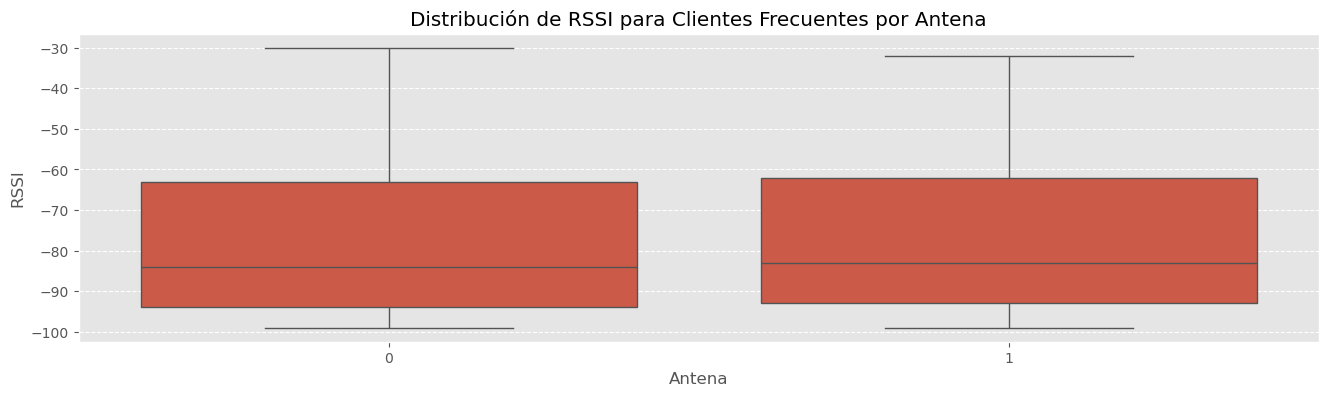

In [15]:
plt.figure(figsize=(16, 4))
sns.boxplot(x='antena', y='rssi', data=df_frequent)
plt.title('Distribución de RSSI para Clientes Frecuentes por Antena')
plt.xlabel('Antena')
plt.ylabel('RSSI')
plt.grid(axis='y', linestyle='--')
plt.show()

In [23]:
df_frequent.groupby(['mac_cliente', 'mac_ap']).count()

banda  antena  rssi
mac_cliente         mac_ap                                    
0.135.1.143.215.55  44.208.45.106.167.16      16      16    16
                    44.208.45.125.172.128     12      12    12
                    44.208.45.127.103.160     20      20    20
0.22.235.183.117.65 0.66.104.213.240.0         8       8     8
                    44.208.45.106.167.16       8       8     8
...                                          ...     ...   ...
8.212.12.243.58.104 0.66.104.213.240.0         4       4     4
                    44.208.45.106.167.16       8       8     8
                    44.208.45.125.172.128      4       4     4
                    44.208.45.127.103.160      8       8     8
                    44.208.45.127.67.64        4       4     4

[292 rows x 3 columns]

In [ ]:
df_frequent.groupby(['mac_cliente', 'mac_ap'])

In [31]:
resultado = (
    df_frequent
    .groupby(['mac_cliente', 'mac_ap'])
    .agg(
        rssi=('rssi','median')
    )
    .reset_index()
)

resultado.to_csv('cliente_ap_rssi.csv', index=False)


In [27]:
resultado = (
    df_frequent
    .groupby(['mac_cliente', 'mac_ap'])
    .size()
    .reset_index(name='cantidad')
)

resultado.to_csv('frecuencia_cliente_ap.csv', index=False)


In [34]:
cliente = "0.22.235.183.117.65"
ap = "44.208.45.125.172.128"

rssi_mes = df_frequent[
    (df_frequent['mac_cliente'] == cliente) &
    (df_frequent['mac_ap'] == ap)
]['rssi']

In [35]:
rssi_mes 

444    -43
445    -41
446    -76
447    -81
4858   -43
4859   -41
4860   -76
4861   -81
Name: rssi, dtype: int64

In [14]:
df = pd.read_csv('buildings/990/processed_rssi_advanced.csv')

In [ ]:
df.sort_values(by='time_step').to_csv('buildings/990/processed_rssi_advanced.csv', index=False)

In [31]:
CSV_PATH = "stats_rssi_2018_11.csv"

df = pd.read_csv(CSV_PATH)

In [32]:
df.describe()

,frecuencia
count,57.000000
mean,4.982456
std,6.898476
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,35.000000


In [33]:
df['frecuencia'].median()

np.float64(2.0)